In [1]:
# A note on what is necessary to run this code
# 0. Jupyter notebook or something else that runs ipynb
# 1. BeautifulSoup 4
# 2. matplotlib
# 3. pandas
# 4. requests
# 5. PIL (pillow)
# Information on how to install can be found on the web if any of these are not installed
# collections is part of the standard python library. If that doesn't work update your python

from collections import Counter
from PIL import Image
import requests
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [2]:
# Class that contains all information you get from scraping one recipe
class DataPoint:
    # Class construction
    def __init__(self, title, image_url, calories, blue, green, purple, summary, key_set):
        self.title = title
        self.image_url = image_url
        self.calories = calories
        self.blue = blue
        self.green = green
        self.purple = purple
        self.summary = summary
        self.key_set = key_set
    
    
    # Less than. used when comparing objects in for example a list.
    def __lt__(self, other):
        return self.calories < other.calories

In [3]:
base = 'https://www.skinnytaste.com'

# Returns the webpage document in memory
# takes the full url as argument
def get_page(url):
    response = requests.get(url)
    response.encoding = 'utf-8'
    return response


# Returns the full url given a specific page number
def get_full_url(page_num):
    if page_num == 0:
        return base
    else:
        return base + '/page/' + str(page_num + 1) + '/'

In [4]:
# The information we want is found under article tags that are either odd or even
def get_odd(soup):
    return soup.find_all('article', class_='post teaser-post odd')


def get_even(soup):
    return soup.find_all('article', class_='post teaser-post even')

In [5]:
# Returns the title of a recipe
# Takes the recipes article tag(parent) as argument
def get_title(parent_tag):
    link_tag = parent_tag.find('a')
    return link_tag.find('h2', class_='title').contents[0]

In [6]:
# Returns the image url of a recipe
# Takes the recipes article tag(parent) as argument
def get_image(parent_tag):
    return parent_tag.find('a').find('img').get('data-lazy-src')

In [7]:
# Returns the all of the point types that exist for the recipe
# Prior to running this we check that they actually exist
# See has_smartpoints() for more information
# Takes the recipes article tag(parent) as argument
def get_smartpoints(parent_tag):
    post_meta_tag = parent_tag.find('div', class_='post-meta')
    recipe_meta_tag = post_meta_tag.find('div', class_='recipe-meta')
    parent_span_tag = recipe_meta_tag.find('span', class_='icon-sp smartpoints')
    
    # Initialize the values to -1 incase they don't exist.
    # Easy to exclude from charts etc. if we see that the value is negative
    blue, green, purple = -1, -1, -1
    if not parent_span_tag.find('span', class_='smart-points blue') is None:
        blue = int(parent_span_tag.find('span', class_='smart-points blue').contents[0])
    if not parent_span_tag.find('span', class_='smart-points green') is None:
        green = int(parent_span_tag.find('span', class_='smart-points green').contents[0])
    if not parent_span_tag.find('span', class_='smart-points purple') is None:
        purple = int(parent_span_tag.find('span', class_='smart-points purple').contents[0])
    return blue, green, purple

In [8]:
# Returns the calorie amount of a recipe
# Takes the recipes article tag(parent) as argument
def get_calories(parent_tag):
    post_meta_tag = parent_tag.find('div', class_='post-meta')
    recipe_meta_tag = post_meta_tag.find('div', class_='recipe-meta')
    nutrition_wrapper_tag = recipe_meta_tag.find('span', class_='wprm-nutrition-wrapper')
    return float(nutrition_wrapper_tag.find('span', class_='recipe-meta-value value-calories divider-right').contents[0])

In [9]:
# Returns all keys that exist for a given recipe
# Takes the recipes article tag(parent) as argument
def get_keys(parent_tag):
    vals = set()
    post_meta_tag = parent_tag.find('div', class_='post-meta')
    icons_tag = post_meta_tag.find('div', class_='icons')
    keys = icons_tag.find_all('span')
    
    # iterate over keys and add to value set
    # using set instead of list due to there not being duplicate keys in a recipe
    for key in keys:
        vals.add(key.find('a').find('img').get('alt'))
    return vals

In [10]:
# Returns the summary for a given recipe
# Takes the recipes article tag(parent) as argument
def get_summary(parent_tag):
    post_content_tag = parent_tag.find('div', class_='post-content')
    return post_content_tag.find('p', class_='excerpt').contents[0]

In [11]:
# Returns True if recipe has smartpoints, else False
# Takes the recipes article tag(parent) as argument
def has_smartpoints(parent_tag):
    post_meta_tag = parent_tag.find('div', class_='post-meta')
    recipe_meta_tag = post_meta_tag.find('div', class_='recipe-meta')
    return not (recipe_meta_tag.find('span', class_='icon-sp smartpoints') is None)


# Returns True if recipe has any keys, else False
# Takes the recipes article tag(parent) as argument
def has_keys(parent_tag):
    post_meta_tag = parent_tag.find('div', class_='post-meta')
    return not (post_meta_tag.find('div', class_='icons') is None)

In [12]:
# There are a handful of entries that are not food of some kind.
# They are recognized by having an empty post-meta tag
# Returns True if article tag represents a recipe
# Takes the recipes article tag(parent) as argument
def is_recipe(parent_tag):
    post_meta_tag = parent_tag.find('div', class_='post-meta')
    return len(post_meta_tag.find_all()) > 0  

In [13]:
# Function that scrapes the data and collects it into a list
# Returns a list of all recipes scraped, empty if none were found
def scrape():
    # Initialize the data list and start scraping
    data = list()
    print('Scraping data')
    
    # iterate through the pages and scrape them
    for i in range(0, 30):
        # add a sleep() here if code doesn't run due to webhost or isp stopping you
        # worked fine for me though
        
        # get the page and parse the article tags into a single ResultSet
        bs = BeautifulSoup(get_page(get_full_url(i)).text, 'html.parser')
        recipes = get_odd(bs)
        recipes.extend(get_even(bs))
        
        # Iterate over the tags and find from that point the wanted information
        for tag in recipes:
            if is_recipe(tag):
                # See the functions above for their usage
                title = get_title(tag)
                image_url = get_image(tag)
                calories = get_calories(tag)
                
                sp = (-1, -1, -1)
                if has_smartpoints(tag):
                    sp = get_smartpoints(tag)
                    
                summary = get_summary(tag)
                
                key_set = set()
                if has_keys(tag):
                    key_set = get_keys(tag)
                
                # Now that we have the information we create a new instance of DataPoint with our information
                # It is finally appended to the list
                data.append(DataPoint(title, image_url, calories, sp[0], sp[1], sp[2], summary, key_set))
    
    # Scraping is done
    print('Scraping finished')
    return data


In [14]:
# Just the call to scrape
# See scrape() for it's usage
data = scrape()

Scraping data
Scraping finished


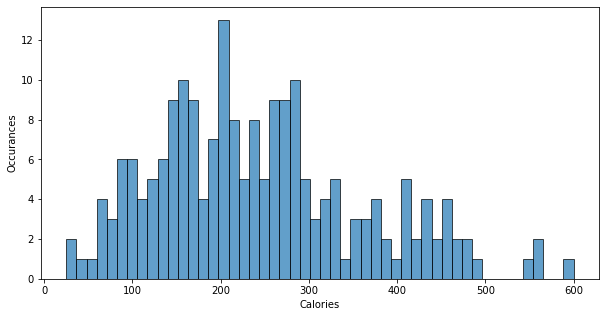

In [15]:
# Create a list for the calorie data
# We retrieve them from the original data list
calorie_list = list()

for point in data:
    calorie_list.append(point.calories)

# Use the calorie data from above to display a histogram
plt.figure(figsize=(10,5))
plt.hist(calorie_list, alpha=0.7, bins=50, ec='k')
plt.xlabel('Calories')
plt.ylabel('Occurances')
plt.show()

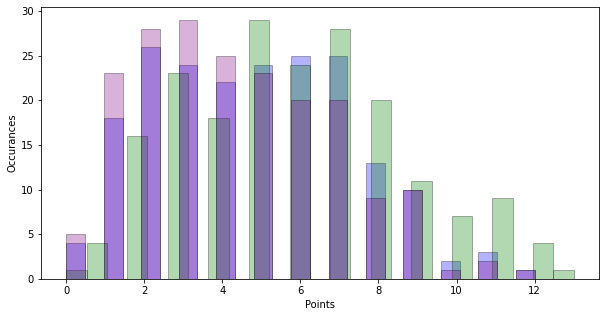

In [16]:
# Create 3 new lists for each type of points. Add data from our original data list to them
blue = list()
green = list()
purple = list()
for point in data:
    if point.blue >= 0:
        blue.append(point.blue)
    if point.green >= 0:
        green.append(point.green)
    if point.purple >= 0:
        purple.append(point.purple)

# Use the data from them to display a overlapping histogram 
plt.figure(figsize=(10,5))
plt.hist(blue, alpha=0.3, bins=25, label='blue points', ec='k', color='blue')
plt.hist(green, alpha=0.3, bins=25, label='green points', ec='k', color='green')
plt.hist(purple, alpha=0.3, bins=25, label='purple points', ec='k', color='purple')
plt.xlabel('Points')
plt.ylabel('Occurances')
plt.show()

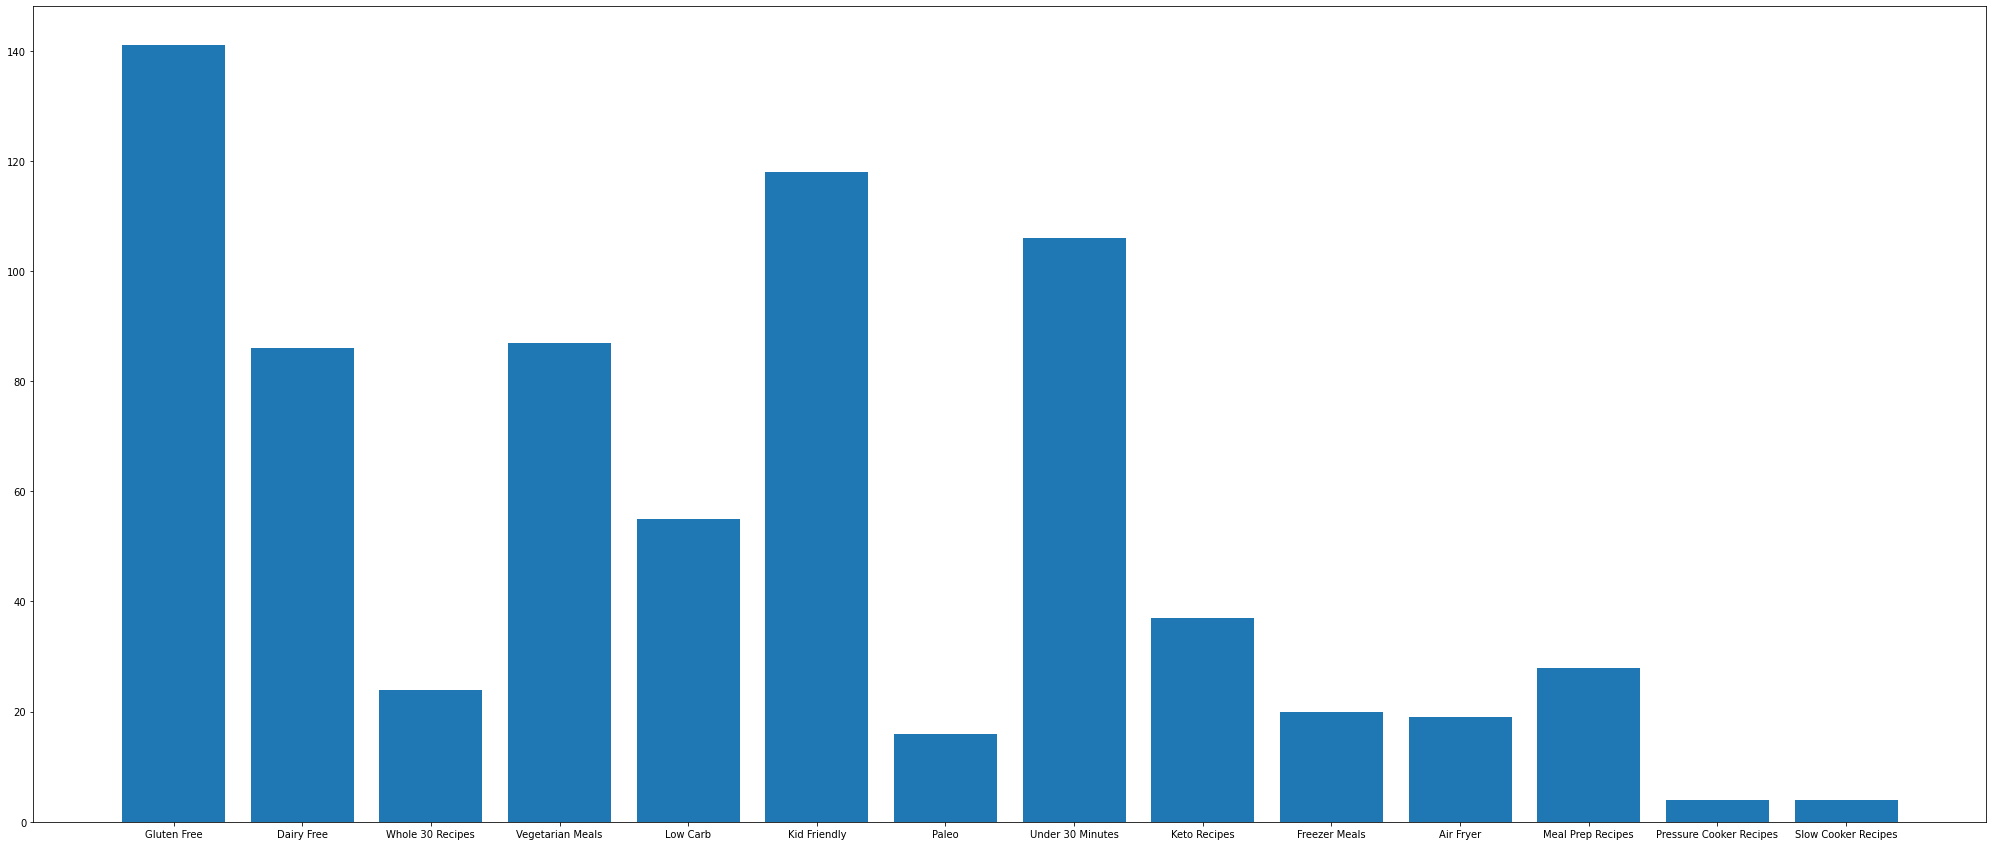

In [17]:
# collect all keys into a list using extend()
keys_total = list()
for point in data:
    keys_total.extend(point.key_set)

# Create a dictionary with a count of each key then use it to display a bar chart
key_counts = Counter(keys_total)
plt.figure(figsize=(35,15))
plt.bar(key_counts.keys(), key_counts.values(), align='center')
plt.show()

In [18]:
# Utility function for getting string inputs
# Takes the input message and list/array of allowed inputs that is used to verify
# Returns the first accepted string value
def get_in(msg, allowed):
    inp = input(msg).lower()
    while inp not in allowed:
        inp = input('The following are allowed ' + str(allowed) + ' ').lower()
    return inp


# Utility function for getting numeric inputs.
# Takes the input message and optionally a minimum value. Initially set to 0
# Returns the first accepted numeric value
def get_in_num(msg, min_val=0):
    inp = input(msg)
    while True:
        if is_num(inp):
            if float(inp) >= min_val:
                break
                
        inp = input('Only numbers allowed. Minimum value is:' + str(min_val) + ' ')
    return float(inp)


# Utility function for checking if a given string value is a number
# Takes a potential numeric value as argument
# Returns True if it represents a numbers, else False
def is_num(val):
    try:
        float(val)
        return True
    except:
        return False

In [19]:
# Function that generates a list of filter parameters from, user input.
# Uses the utility functions above
# Returns a list of filter parameters that allows the filtering of our data to suit the user
def filter_params():
    filter_ = get_in('Would you like to filter? (enter y to filter else enter n)', ['y','n'])
    # We collect additional filters if y was answered
    if filter_ == 'y':
        # Collect calorie upper and lower limits for filter
        c_low = get_in_num('Enter a lower bound for the calories.')
        c_high = get_in_num('Enter a upper bound for the calories.', min_val=(c_low+0.1))
        
        # We collect additional filters if y was answered
        p_filter = get_in('Would you like to filter by points? (enter y to filter else enter n)', ['y','n'])
        if p_filter == 'y':
            # Collect point filters
            p_type = get_in('Enter the point colour (blue, green, purple)', ['blue','green','purple'])
            p_low = get_in_num('Enter a lower bound for the points.')
            p_high = get_in_num('Enter a upper bound for the points.', min_val=(p_low+0.1))
            return [True, c_low, c_high, True, p_type, p_low, p_high]
        return [True, c_low, c_high, False]
    return [False]
    

# Function that creates a copy of our data and filters the copy
# Takes the original data list and list of filter parameters as arguments
# Returns the filtered list. May be unmodified if no filtering is applied
def filter_data(data, params):
    l = data[:]
    # if [0] is True then there are filters to apply, else we're done
    if params[0]:
        # filter out incorrect calorie recipes
        l = [p for p in l if (params[1] <= p.calories <= params[2])]
        # if [3] is True then there are point filters to apply, else we're done
        if params[3]:
            # filter out incorrect point values from our list
            l = [p for p in l if params[5] <= getattr(p, params[4]) <= params[6]]
            
    return l


Would you like to filter? (enter y to filter else enter n) y
Enter a lower bound for the calories. 25
Enter a upper bound for the calories. 80
Would you like to filter by points? (enter y to filter else enter n) y
Enter the point colour (blue, green, purple) gren
The following are allowed ['blue', 'green', 'purple']  green
Enter a lower bound for the points. 2
Enter a upper bound for the points. 6


---------------------------------------------------------------


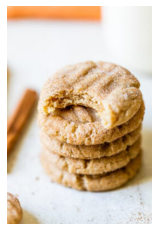

This Baked Pumpkin Pasta is made with pancetta, kale, and white beans and topped with gruyere and panko crumbs. Baked Pumpkin Pasta This healthy baked pumpkin pasta bake is...
---------------------------------------------------------------


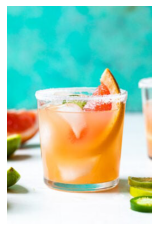

My Mom makes the BEST Thanksgiving stuffing, it’s the one thing I crave every year more than the turkey! This recipe has been remade like Mom’s, only just a...
---------------------------------------------------------------


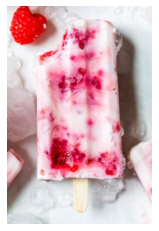

This simple side dish of Roasted Green Beans with Caramelized Onions pairs wonderfully with Thanksgiving turkey or roasted chicken. Green Beans with Caramelized Onions This Roasted Green Bean recipe...
---------------------------------------------------------------


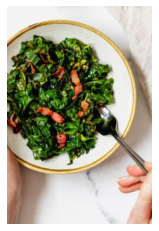

This easy makeover Spinach Gratin is creamy and decadent, with a hint of nutmeg baked in the oven topped with melted Gruyere cheese for a must at your Holiday...
---------------------------------------------------------------


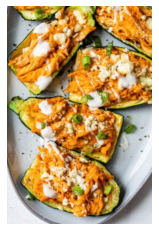

This Turkey Pot Pie with Sweet Potato Topping screams comfort food! A delicious way to use up your Thanksgiving leftovers. Turkey Pot Pie with Sweet Potato Topping As a...
---------------------------------------------------------------


In [20]:
# collect parameters for filtering. Filter and then sort the data
params = filter_params()
filtered = filter_data(data, params)
# See DataPoint for comparison implementation
filtered.sort()


# If we have filtered out so many that we have less than 5 left then we display what we can
# Otherwise display the 5 we need to display, sorted by calories
print('---------------------------------------------------------------')
if len(filtered) < 5:
    print('Could only display ' + len(filtered) + ' due to excessive filtering')
    print('---------------------------------------------------------------')
    for i in range(len(filtered)):
        im = Image.open(requests.get(filtered[i].image_url, stream=True).raw)
        plt.imshow(im)
        plt.axis('off')
        plt.show()
        print(data[i].summary)
        print('---------------------------------------------------------------')

else:
    for i in range(5):
        im = Image.open(requests.get(filtered[i].image_url, stream=True).raw)
        plt.imshow(im)
        plt.axis('off')
        plt.show()
        print(data[i].summary)
        print('---------------------------------------------------------------')